In [2]:
# Import
import osmnx as ox 
import matplotlib as mpl 
%matplotlib inline
from matplotlib import pyplot as plt
import os
import pandas as pd
import geopandas as gpd
import numpy as np
# Set up query
query = {'amenity':'restaurant'}

# Run query
restaurants_gdf = ox.geometries.geometries_from_place(
            'Greater London, UK',
            tags = query)

restaurants_gdf.head(5)

KeyboardInterrupt: 

                                            geometry  bbox_north  bbox_south  \
0  POLYGON ((-0.51038 51.46809, -0.51036 51.46795...   51.691874    51.28676   

   bbox_east  bbox_west   place_id  osm_type  osm_id        lat       lon  \
0   0.334016  -0.510375  297636960  relation  175342  51.489334 -0.144055   

                              display_name     class            type  \
0  Greater London, England, United Kingdom  boundary  administrative   

   importance  
0    0.802637  


C:\Users\amran\AppData\Local\Temp\ipykernel_17368\3190262929.py:11: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


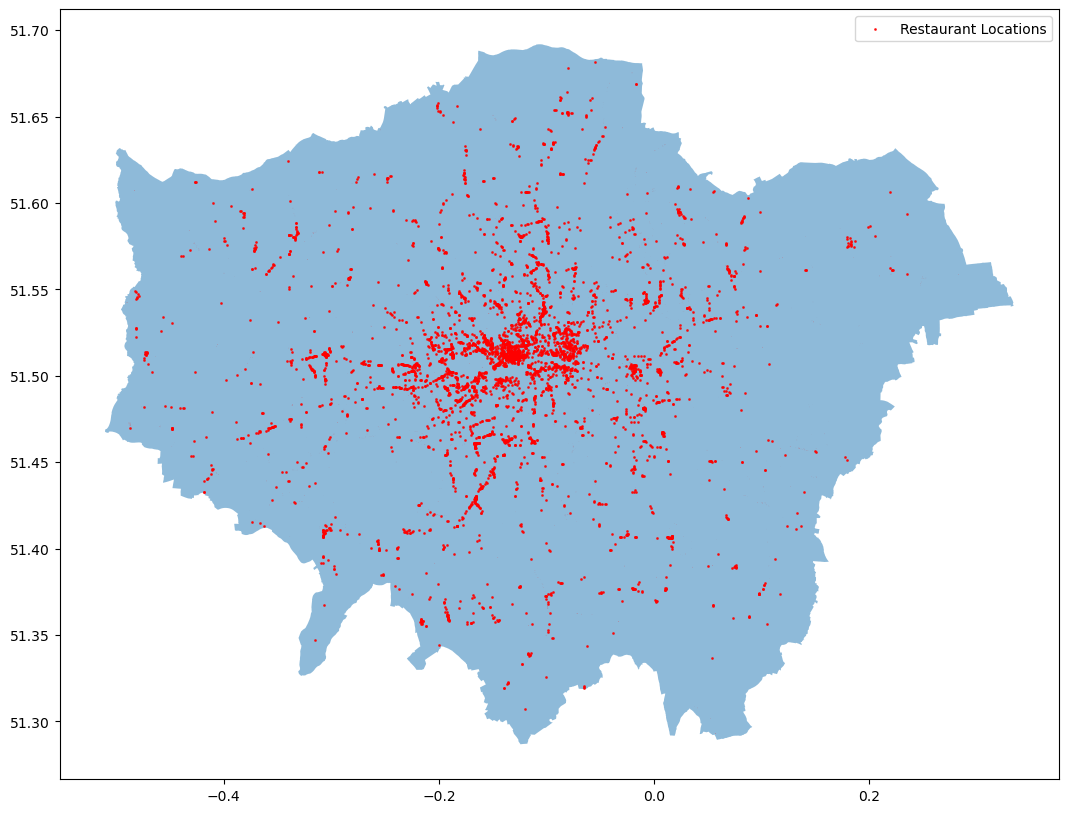

In [2]:
# Download London's Boundary
london_gdf = ox.geocoder.geocode_to_gdf('Greater London, UK')

print(london_gdf.head(5))
# Set up a plot axis
fig, ax = plt.subplots(figsize = (15,10))

# Visualise both on the plot
london_gdf.plot(ax = ax, alpha = 0.5)
restaurants_gdf.plot(ax = ax, markersize = 1, color = 'red', alpha = 0.8, label = 'Restaurant Locations')
plt.legend()



In [3]:
from shapely.geometry.polygon import Polygon
from shapely.geometry.multipolygon import MultiPolygon

london_gdf['geometry'] = london_gdf['geometry'].apply(
  lambda x: x.centroid if type(x) == Polygon else (
  x.centroid if type(x) == MultiPolygon else x)
)

In [4]:
def get_local_crs(y,x):  
    x = ox.utils_geo.bbox_from_point((y, x), dist = 500, project_utm = True, return_crs = True)
    return x[-1]
  
# Set London longitude and latitude
lon_latitude = 51.509865
lon_longitude = -0.118092

local_utm_crs = get_local_crs(lon_latitude, lon_longitude)

In [5]:

# Import our AirBnb room data
air_df = pd.read_csv('airbnb_rooms.csv')

# Note below: "crs = 4326" is our way of telling geopandas that the initial projection uses the standard
# longitude latitude coordinates. You can't manipulate the CRS if you haven't set one initially.

air_gdf = gpd.GeoDataFrame(air_df, geometry = gpd.points_from_xy(air_df.longitude, air_df.latitude), crs = 4326)
air_gdf = air_gdf.to_crs(local_utm_crs)

#Convert amenities into local projection (amenities already had an initial CRS set when we downloaded it via OSMnx)
restaurants_gdf = restaurants_gdf.to_crs(local_utm_crs)

In [6]:
import time
from scipy import spatial
from scipy.spatial import KDTree

points = restaurants_gdf[restaurants_gdf.geometry.type == 'Point']
Lon = points.geometry.apply(lambda x: x.x).values
Lat = points.geometry.apply(lambda x: x.y).values
coords = list(zip(Lat,Lon))
tree = spatial.KDTree(coords)
Lon = []
Lat = []
for geom in restaurants_gdf.geometry:
    if geom.type == 'Point':
        Lon.append(geom.x)
        Lat.append(geom.y)
    elif geom.type == 'Polygon':
        Lon.append(geom.centroid.x)
        Lat.append(geom.centroid.y)
coords = list(zip(Lat, Lon))
tree = spatial.KDTree(coords)

In [7]:
def find_points_closeby(lat_lon, k = 500, max_distance = 1000 ):
  '''
  Queries a pre-existing kd tree and returns the number of points within x distance
  of long/lat point.
  lat_lon:        A longitude and latitude pairings in the (y, x) tuple form.
  k:              The maximum number of closest points to query
  max_distance:   The maximum distance (in meters)
  '''
  
  results = tree.query((lat_lon), k = k, distance_upper_bound= max_distance)
  zipped_results = list(zip(results[0], results[1]))
  zipped_results = [i for i in zipped_results if i[0] != np.inf]
  
  return len(zipped_results)

In [8]:
# Set up a timer 
import time 
t0 = time.time()

#Apply the function
air_gdf['restaurants'] = air_gdf.apply(lambda row: find_points_closeby(
  (row.geometry.y, row.geometry.x)) , axis = 1)

# Report the time
time_passed = round(time.time() - t0, 2)
print ("Completed in %s seconds" % (time_passed))

Completed in 12.63 seconds


In [9]:
air_gdf[['id','restaurants']].head(5)

,id,restaurants
0,13913,45
1,15400,125
2,17402,148
3,25023,0
4,25123,9


All In One

restaurant
                                            geometry  bbox_north  bbox_south  \
0  POLYGON ((-0.51038 51.46809, -0.51036 51.46795...   51.691874    51.28676   

   bbox_east  bbox_west   place_id  osm_type  osm_id        lat       lon  \
0   0.334016  -0.510375  297636960  relation  175342  51.489334 -0.144055   

                              display_name     class            type  \
0  Greater London, England, United Kingdom  boundary  administrative   

   importance  
0    0.802637  


C:\Users\amran\AppData\Local\Temp\ipykernel_14076\3714795702.py:46: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()
C:\Users\amran\AppData\Local\Temp\ipykernel_14076\3714795702.py:84: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom.type == 'Point':
C:\Users\amran\AppData\Local\Temp\ipykernel_14076\3714795702.py:87: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  elif geom.type == 'Polygon':


Completed in 26.16 seconds
      id  restaurant
0  13913           3
1  15400         140
2  17402         329
3  25023           2
4  25123          11
bar
                                            geometry  bbox_north  bbox_south  \
0  POLYGON ((-0.51038 51.46809, -0.51036 51.46795...   51.691874    51.28676   

   bbox_east  bbox_west   place_id  osm_type  osm_id        lat       lon  \
0   0.334016  -0.510375  297636960  relation  175342  51.489334 -0.144055   

                              display_name     class            type  \
0  Greater London, England, United Kingdom  boundary  administrative   

   importance  
0    0.802637  


C:\Users\amran\AppData\Local\Temp\ipykernel_14076\3714795702.py:46: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()
C:\Users\amran\AppData\Local\Temp\ipykernel_14076\3714795702.py:84: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom.type == 'Point':
C:\Users\amran\AppData\Local\Temp\ipykernel_14076\3714795702.py:87: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  elif geom.type == 'Polygon':


Completed in 24.58 seconds
      id  bar
0  13913    0
1  15400   12
2  17402   48
3  25023    0
4  25123    0
pub
                                            geometry  bbox_north  bbox_south  \
0  POLYGON ((-0.51038 51.46809, -0.51036 51.46795...   51.691874    51.28676   

   bbox_east  bbox_west   place_id  osm_type  osm_id        lat       lon  \
0   0.334016  -0.510375  297636960  relation  175342  51.489334 -0.144055   

                              display_name     class            type  \
0  Greater London, England, United Kingdom  boundary  administrative   

   importance  
0    0.802637  


C:\Users\amran\AppData\Local\Temp\ipykernel_14076\3714795702.py:46: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()
C:\Users\amran\AppData\Local\Temp\ipykernel_14076\3714795702.py:84: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom.type == 'Point':
C:\Users\amran\AppData\Local\Temp\ipykernel_14076\3714795702.py:87: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  elif geom.type == 'Polygon':


Completed in 25.54 seconds
      id  pub
0  13913    1
1  15400   22
2  17402   91
3  25023    3
4  25123    1
hospital
                                            geometry  bbox_north  bbox_south  \
0  POLYGON ((-0.51038 51.46809, -0.51036 51.46795...   51.691874    51.28676   

   bbox_east  bbox_west   place_id  osm_type  osm_id        lat       lon  \
0   0.334016  -0.510375  297636960  relation  175342  51.489334 -0.144055   

                              display_name     class            type  \
0  Greater London, England, United Kingdom  boundary  administrative   

   importance  
0    0.802637  


C:\Users\amran\AppData\Local\Temp\ipykernel_14076\3714795702.py:46: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()
C:\Users\amran\AppData\Local\Temp\ipykernel_14076\3714795702.py:84: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom.type == 'Point':
C:\Users\amran\AppData\Local\Temp\ipykernel_14076\3714795702.py:87: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  elif geom.type == 'Polygon':


Completed in 24.88 seconds
      id  hospital
0  13913         0
1  15400         4
2  17402        13
3  25023         1
4  25123         0
cinema
                                            geometry  bbox_north  bbox_south  \
0  POLYGON ((-0.51038 51.46809, -0.51036 51.46795...   51.691874    51.28676   

   bbox_east  bbox_west   place_id  osm_type  osm_id        lat       lon  \
0   0.334016  -0.510375  297636960  relation  175342  51.489334 -0.144055   

                              display_name     class            type  \
0  Greater London, England, United Kingdom  boundary  administrative   

   importance  
0    0.802637  


C:\Users\amran\AppData\Local\Temp\ipykernel_14076\3714795702.py:46: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()
C:\Users\amran\AppData\Local\Temp\ipykernel_14076\3714795702.py:84: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom.type == 'Point':
C:\Users\amran\AppData\Local\Temp\ipykernel_14076\3714795702.py:87: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  elif geom.type == 'Polygon':


Completed in 24.71 seconds
      id  cinema
0  13913       0
1  15400       3
2  17402       2
3  25023       0
4  25123       0
nightclub
                                            geometry  bbox_north  bbox_south  \
0  POLYGON ((-0.51038 51.46809, -0.51036 51.46795...   51.691874    51.28676   

   bbox_east  bbox_west   place_id  osm_type  osm_id        lat       lon  \
0   0.334016  -0.510375  297636960  relation  175342  51.489334 -0.144055   

                              display_name     class            type  \
0  Greater London, England, United Kingdom  boundary  administrative   

   importance  
0    0.802637  


C:\Users\amran\AppData\Local\Temp\ipykernel_14076\3714795702.py:46: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()
C:\Users\amran\AppData\Local\Temp\ipykernel_14076\3714795702.py:84: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom.type == 'Point':
C:\Users\amran\AppData\Local\Temp\ipykernel_14076\3714795702.py:87: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  elif geom.type == 'Polygon':


Completed in 25.63 seconds
      id  nightclub
0  13913          0
1  15400          4
2  17402         15
3  25023          0
4  25123          0
theatre
                                            geometry  bbox_north  bbox_south  \
0  POLYGON ((-0.51038 51.46809, -0.51036 51.46795...   51.691874    51.28676   

   bbox_east  bbox_west   place_id  osm_type  osm_id        lat       lon  \
0   0.334016  -0.510375  297636960  relation  175342  51.489334 -0.144055   

                              display_name     class            type  \
0  Greater London, England, United Kingdom  boundary  administrative   

   importance  
0    0.802637  


C:\Users\amran\AppData\Local\Temp\ipykernel_14076\3714795702.py:46: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()
C:\Users\amran\AppData\Local\Temp\ipykernel_14076\3714795702.py:84: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom.type == 'Point':
C:\Users\amran\AppData\Local\Temp\ipykernel_14076\3714795702.py:87: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  elif geom.type == 'Polygon':


Completed in 10.29 seconds
      id  theatre
0  13913        0
1  15400        0
2  17402        9
3  25023        0
4  25123        0
marketplace
                                            geometry  bbox_north  bbox_south  \
0  POLYGON ((-0.51038 51.46809, -0.51036 51.46795...   51.691874    51.28676   

   bbox_east  bbox_west   place_id  osm_type  osm_id        lat       lon  \
0   0.334016  -0.510375  297636960  relation  175342  51.489334 -0.144055   

                              display_name     class            type  \
0  Greater London, England, United Kingdom  boundary  administrative   

   importance  
0    0.802637  


C:\Users\amran\AppData\Local\Temp\ipykernel_14076\3714795702.py:46: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()
C:\Users\amran\AppData\Local\Temp\ipykernel_14076\3714795702.py:84: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom.type == 'Point':
C:\Users\amran\AppData\Local\Temp\ipykernel_14076\3714795702.py:87: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  elif geom.type == 'Polygon':


Completed in 9.64 seconds
      id  marketplace
0  13913            0
1  15400            3
2  17402            3
3  25023            0
4  25123            0
place_of_worship
                                            geometry  bbox_north  bbox_south  \
0  POLYGON ((-0.51038 51.46809, -0.51036 51.46795...   51.691874    51.28676   

   bbox_east  bbox_west   place_id  osm_type  osm_id        lat       lon  \
0   0.334016  -0.510375  297636960  relation  175342  51.489334 -0.144055   

                              display_name     class            type  \
0  Greater London, England, United Kingdom  boundary  administrative   

   importance  
0    0.802637  


C:\Users\amran\AppData\Local\Temp\ipykernel_14076\3714795702.py:46: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()
C:\Users\amran\AppData\Local\Temp\ipykernel_14076\3714795702.py:84: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom.type == 'Point':
C:\Users\amran\AppData\Local\Temp\ipykernel_14076\3714795702.py:87: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  elif geom.type == 'Polygon':


Completed in 9.26 seconds
      id  place_of_worship
0  13913                 2
1  15400                18
2  17402                27
3  25023                 5
4  25123                11


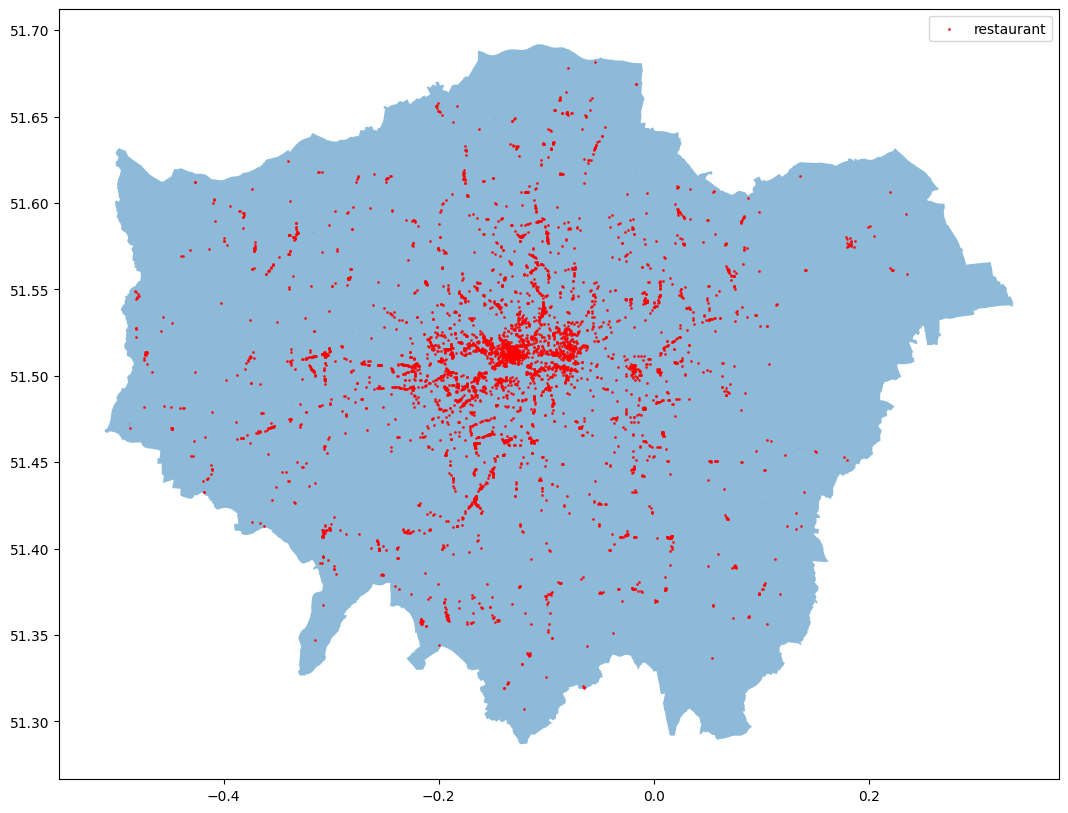

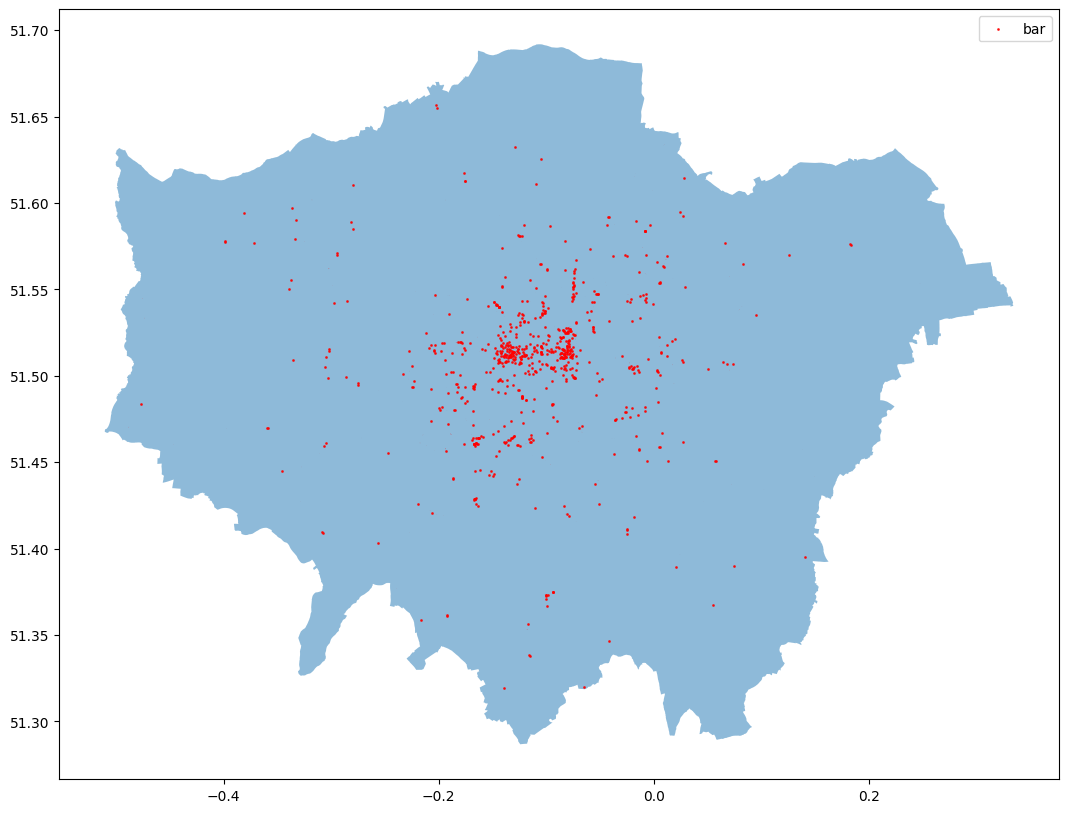

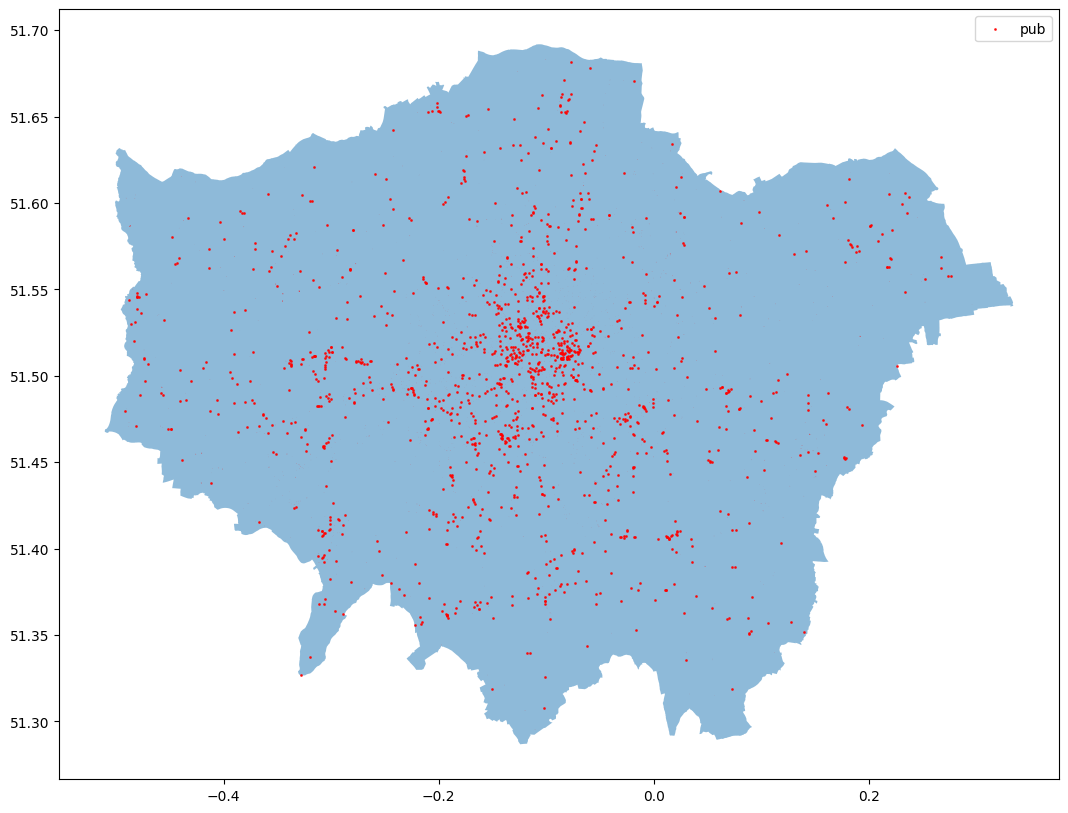

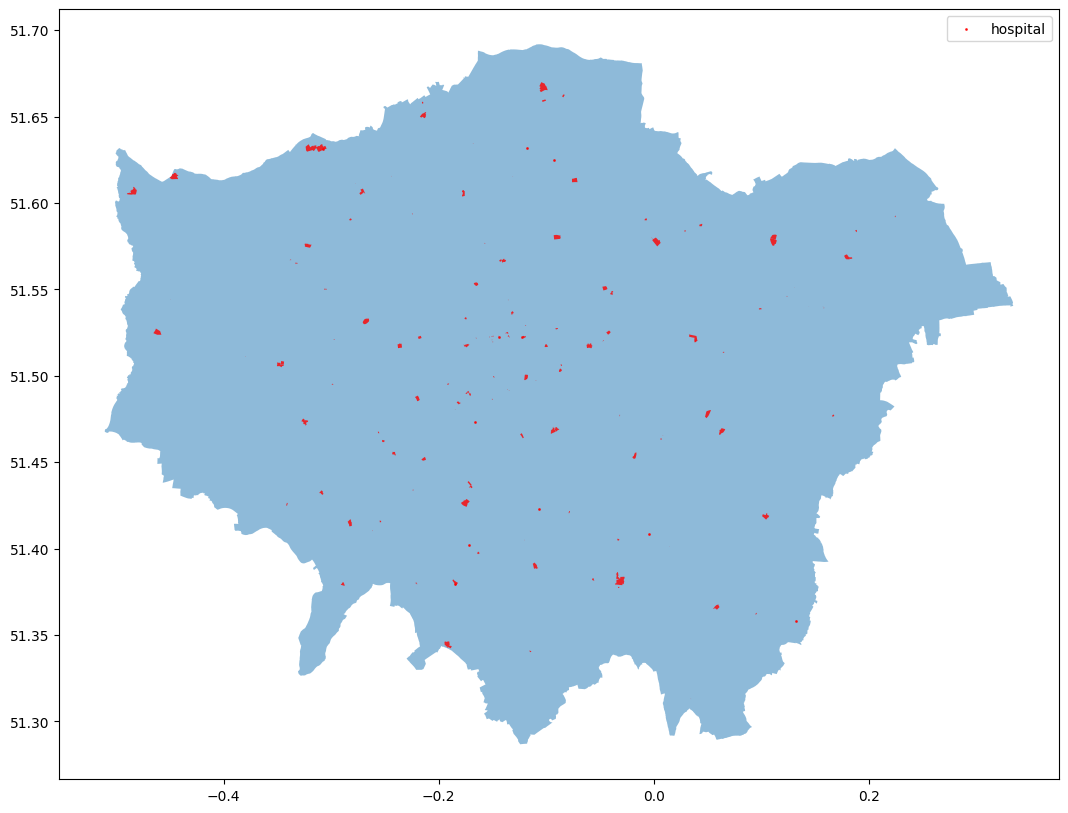

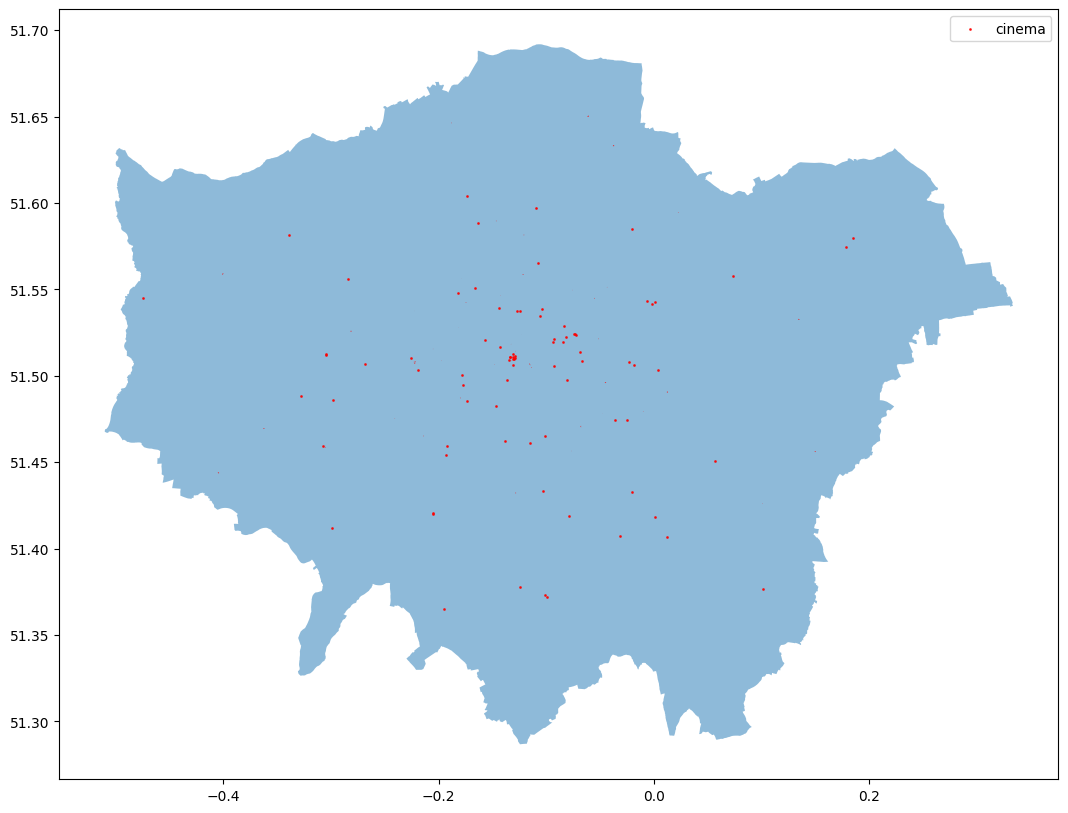

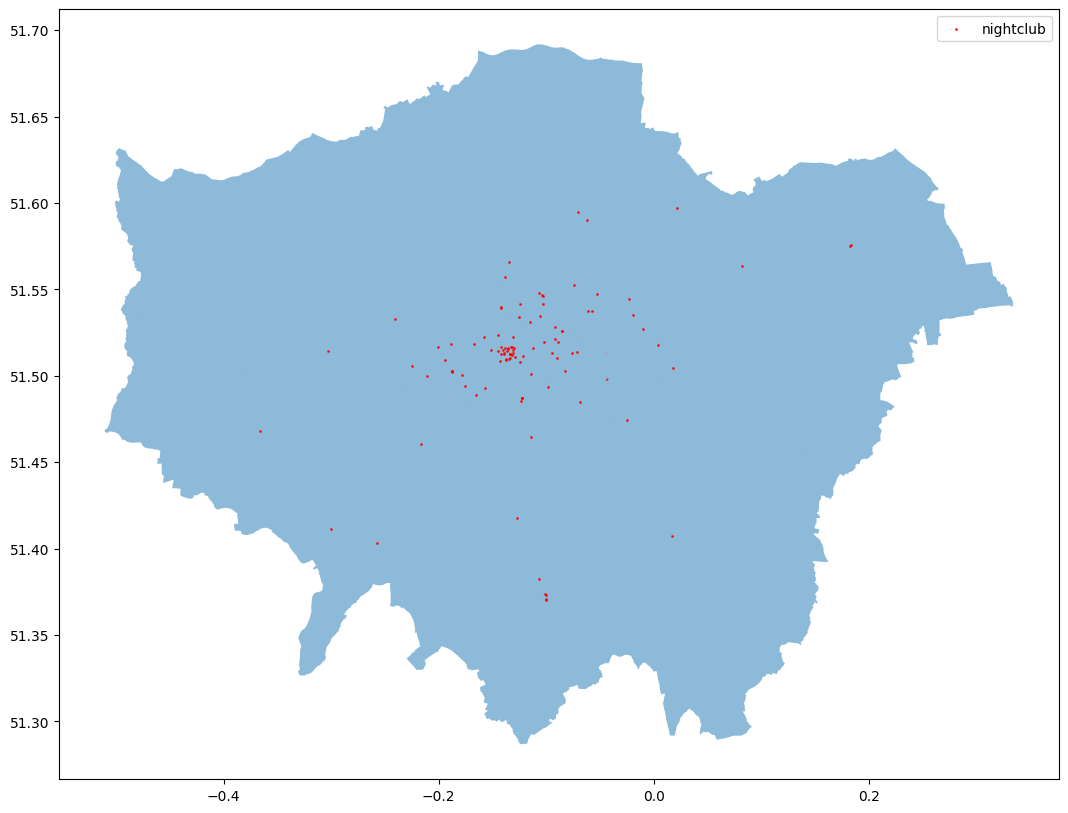

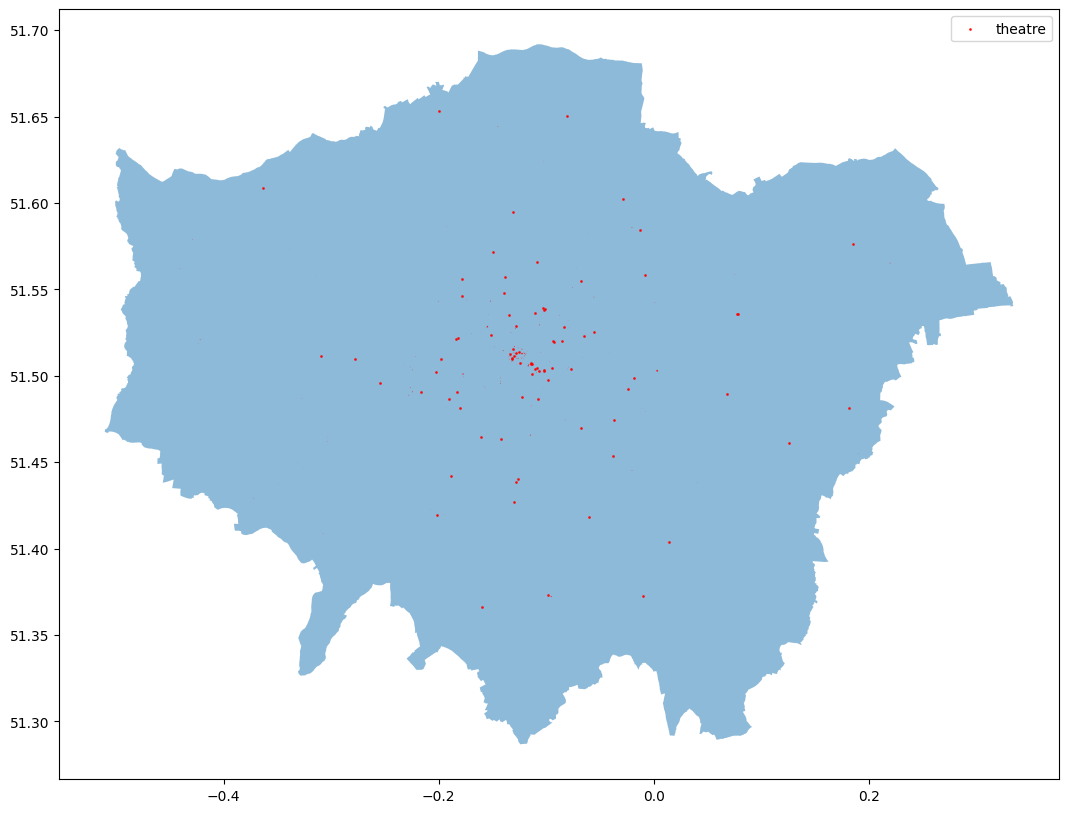

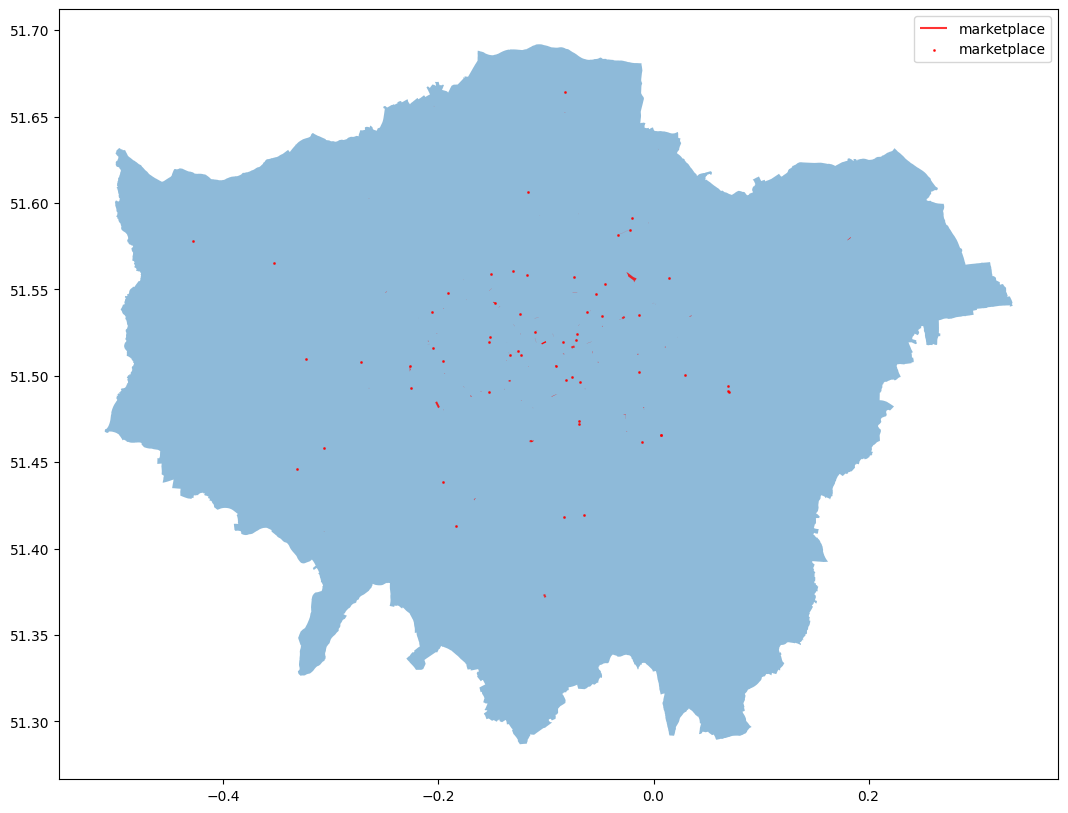

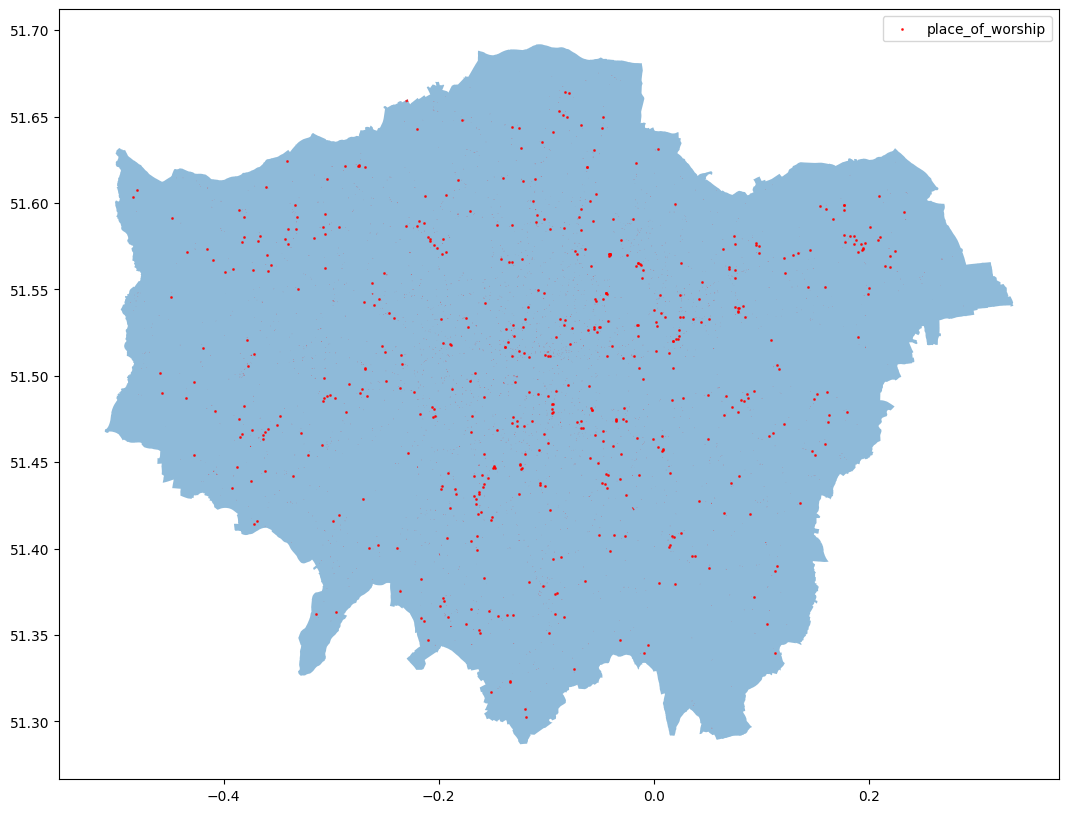

In [3]:
# Import
import osmnx as ox 
import matplotlib as mpl 
%matplotlib inline
from matplotlib import pyplot as plt
import os
import pandas as pd
import geopandas as gpd
import numpy as np
from shapely.geometry.polygon import Polygon
from shapely.geometry.multipolygon import MultiPolygon
import time
from scipy import spatial
from scipy.spatial import KDTree
import pickle

# Import our AirBnb room data
air_df = pd.read_csv('airbnb_rooms.csv')

# Set up query
amenity_list = ['restaurant','bar','pub','hospital','cinema','nightclub','theatre','marketplace','place_of_worship']

for u in amenity_list:
  print(u)
  query = {'amenity':u}

  # Run query
  restaurants_gdf = ox.geometries.geometries_from_place(
              'Greater London, UK',
              tags = query)

  restaurants_gdf.head(5)

  #-----plotting start-------
  
  # Download London's Boundary
  london_gdf = ox.geocoder.geocode_to_gdf('Greater London, UK')

  print(london_gdf.head(5))
  # Set up a plot axis
  fig, ax = plt.subplots(figsize = (15,10))

  # Visualise both on the plot
  london_gdf.plot(ax = ax, alpha = 0.5)
  restaurants_gdf.plot(ax = ax, markersize = 1, color = 'red', alpha = 0.8, label = u)
  plt.legend()

  #-----plotting end------


  london_gdf['geometry'] = london_gdf['geometry'].apply(
    lambda x: x.centroid if type(x) == Polygon else (
    x.centroid if type(x) == MultiPolygon else x)
  )


  def get_local_crs(y,x):  
      x = ox.utils_geo.bbox_from_point((y, x), dist = 500, project_utm = True, return_crs = True)
      return x[-1]
    
  # Set London longitude and latitude
  lon_latitude = 51.509865
  lon_longitude = -0.118092

  local_utm_crs = get_local_crs(lon_latitude, lon_longitude)

  # Note below: "crs = 4326" is our way of telling geopandas that the initial projection uses the standard
  # longitude latitude coordinates. You can't manipulate the CRS if you haven't set one initially.

  air_gdf = gpd.GeoDataFrame(air_df, geometry = gpd.points_from_xy(air_df.longitude, air_df.latitude), crs = 4326)
  air_gdf = air_gdf.to_crs(local_utm_crs)

  #Convert amenities into local projection (amenities already had an initial CRS set when we downloaded it via OSMnx)
  restaurants_gdf = restaurants_gdf.to_crs(local_utm_crs)

  points = restaurants_gdf[restaurants_gdf.geometry.type == 'Point']
  Lon = points.geometry.apply(lambda x: x.x).values
  Lat = points.geometry.apply(lambda x: x.y).values
  coords = list(zip(Lat,Lon))
  tree = spatial.KDTree(coords)
  Lon = []
  Lat = []
  for geom in restaurants_gdf.geometry:
      if geom.type == 'Point':
          Lon.append(geom.x)
          Lat.append(geom.y)
      elif geom.type == 'Polygon':
          Lon.append(geom.centroid.x)
          Lat.append(geom.centroid.y)
  coords = list(zip(Lat, Lon))
  tree = spatial.KDTree(coords)

  file_name = f'D:/React-Projects/Mini-project/pickled_kdtree/kdtree_{u}.pkl'
  with open(file_name, 'wb') as file:
    pickle.dump(tree, file)

  def find_points_closeby(lat_lon, k = 500, max_distance = 1000 ):
    '''
    Queries a pre-existing kd tree and returns the number of points within x distance
    of long/lat point.
    lat_lon:        A longitude and latitude pairings in the (y, x) tuple form.
    k:              The maximum number of closest points to query
    max_distance:   The maximum distance (in meters)
    '''
    
    results = tree.query((lat_lon), k = k, distance_upper_bound= max_distance)
    zipped_results = list(zip(results[0], results[1]))
    zipped_results = [i for i in zipped_results if i[0] != np.inf]
    return len(zipped_results)

  # Set up a timer 
  import time 
  t0 = time.time()


  #Apply the function
  air_df[u] = air_gdf.apply(lambda row: find_points_closeby(
    (row.geometry.y, row.geometry.x)) , axis = 1)

  # Report the time
  time_passed = round(time.time() - t0, 2)
  print ("Completed in %s seconds" % (time_passed))

  print(air_df[['id',u]].head(5))


  

Tourism

artwork
                                            geometry  bbox_north  bbox_south  \
0  POLYGON ((-0.51038 51.46809, -0.51036 51.46795...   51.691874    51.28676   

   bbox_east  bbox_west   place_id  osm_type  osm_id        lat       lon  \
0   0.334016  -0.510375  297636960  relation  175342  51.489334 -0.144055   

                              display_name     class            type  \
0  Greater London, England, United Kingdom  boundary  administrative   

   importance  
0    0.802637  


C:\Users\amran\AppData\Local\Temp\ipykernel_14076\30209181.py:40: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()
C:\Users\amran\AppData\Local\Temp\ipykernel_14076\30209181.py:77: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom.type == 'Point':
C:\Users\amran\AppData\Local\Temp\ipykernel_14076\30209181.py:80: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  elif geom.type == 'Polygon':


Completed in 9.5 seconds
      id  artwork
0  13913        0
1  15400       14
2  17402       35
3  25023        0
4  25123        0
attraction
                                            geometry  bbox_north  bbox_south  \
0  POLYGON ((-0.51038 51.46809, -0.51036 51.46795...   51.691874    51.28676   

   bbox_east  bbox_west   place_id  osm_type  osm_id        lat       lon  \
0   0.334016  -0.510375  297636960  relation  175342  51.489334 -0.144055   

                              display_name     class            type  \
0  Greater London, England, United Kingdom  boundary  administrative   

   importance  
0    0.802637  


C:\Users\amran\AppData\Local\Temp\ipykernel_14076\30209181.py:40: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()
C:\Users\amran\AppData\Local\Temp\ipykernel_14076\30209181.py:77: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom.type == 'Point':
C:\Users\amran\AppData\Local\Temp\ipykernel_14076\30209181.py:80: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  elif geom.type == 'Polygon':


Completed in 8.98 seconds
      id  attraction
0  13913           0
1  15400           9
2  17402           8
3  25023           0
4  25123           0
gallery
                                            geometry  bbox_north  bbox_south  \
0  POLYGON ((-0.51038 51.46809, -0.51036 51.46795...   51.691874    51.28676   

   bbox_east  bbox_west   place_id  osm_type  osm_id        lat       lon  \
0   0.334016  -0.510375  297636960  relation  175342  51.489334 -0.144055   

                              display_name     class            type  \
0  Greater London, England, United Kingdom  boundary  administrative   

   importance  
0    0.802637  


C:\Users\amran\AppData\Local\Temp\ipykernel_14076\30209181.py:40: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()
C:\Users\amran\AppData\Local\Temp\ipykernel_14076\30209181.py:77: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom.type == 'Point':
C:\Users\amran\AppData\Local\Temp\ipykernel_14076\30209181.py:80: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  elif geom.type == 'Polygon':


Completed in 9.1 seconds
      id  gallery
0  13913        0
1  15400       17
2  17402       20
3  25023        0
4  25123        0
information
                                            geometry  bbox_north  bbox_south  \
0  POLYGON ((-0.51038 51.46809, -0.51036 51.46795...   51.691874    51.28676   

   bbox_east  bbox_west   place_id  osm_type  osm_id        lat       lon  \
0   0.334016  -0.510375  297636960  relation  175342  51.489334 -0.144055   

                              display_name     class            type  \
0  Greater London, England, United Kingdom  boundary  administrative   

   importance  
0    0.802637  


C:\Users\amran\AppData\Local\Temp\ipykernel_14076\30209181.py:40: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()
C:\Users\amran\AppData\Local\Temp\ipykernel_14076\30209181.py:77: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom.type == 'Point':
C:\Users\amran\AppData\Local\Temp\ipykernel_14076\30209181.py:80: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  elif geom.type == 'Polygon':


Completed in 9.13 seconds
      id  information
0  13913            2
1  15400           11
2  17402           54
3  25023            0
4  25123            2
museum
                                            geometry  bbox_north  bbox_south  \
0  POLYGON ((-0.51038 51.46809, -0.51036 51.46795...   51.691874    51.28676   

   bbox_east  bbox_west   place_id  osm_type  osm_id        lat       lon  \
0   0.334016  -0.510375  297636960  relation  175342  51.489334 -0.144055   

                              display_name     class            type  \
0  Greater London, England, United Kingdom  boundary  administrative   

   importance  
0    0.802637  


C:\Users\amran\AppData\Local\Temp\ipykernel_14076\30209181.py:40: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()
C:\Users\amran\AppData\Local\Temp\ipykernel_14076\30209181.py:77: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom.type == 'Point':
C:\Users\amran\AppData\Local\Temp\ipykernel_14076\30209181.py:80: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  elif geom.type == 'Polygon':


Completed in 8.96 seconds
      id  museum
0  13913       0
1  15400       2
2  17402      12
3  25023       0
4  25123       0
picnic_site
                                            geometry  bbox_north  bbox_south  \
0  POLYGON ((-0.51038 51.46809, -0.51036 51.46795...   51.691874    51.28676   

   bbox_east  bbox_west   place_id  osm_type  osm_id        lat       lon  \
0   0.334016  -0.510375  297636960  relation  175342  51.489334 -0.144055   

                              display_name     class            type  \
0  Greater London, England, United Kingdom  boundary  administrative   

   importance  
0    0.802637  


C:\Users\amran\AppData\Local\Temp\ipykernel_14076\30209181.py:40: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()
C:\Users\amran\AppData\Local\Temp\ipykernel_14076\30209181.py:77: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom.type == 'Point':
C:\Users\amran\AppData\Local\Temp\ipykernel_14076\30209181.py:80: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  elif geom.type == 'Polygon':


Completed in 9.19 seconds
      id  picnic_site
0  13913            0
1  15400            0
2  17402            1
3  25023            0
4  25123            1
viewpoint
                                            geometry  bbox_north  bbox_south  \
0  POLYGON ((-0.51038 51.46809, -0.51036 51.46795...   51.691874    51.28676   

   bbox_east  bbox_west   place_id  osm_type  osm_id        lat       lon  \
0   0.334016  -0.510375  297636960  relation  175342  51.489334 -0.144055   

                              display_name     class            type  \
0  Greater London, England, United Kingdom  boundary  administrative   

   importance  
0    0.802637  


C:\Users\amran\AppData\Local\Temp\ipykernel_14076\30209181.py:40: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()
C:\Users\amran\AppData\Local\Temp\ipykernel_14076\30209181.py:77: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom.type == 'Point':
C:\Users\amran\AppData\Local\Temp\ipykernel_14076\30209181.py:80: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  elif geom.type == 'Polygon':


Completed in 9.21 seconds
      id  viewpoint
0  13913          0
1  15400          0
2  17402          0
3  25023          0
4  25123          0


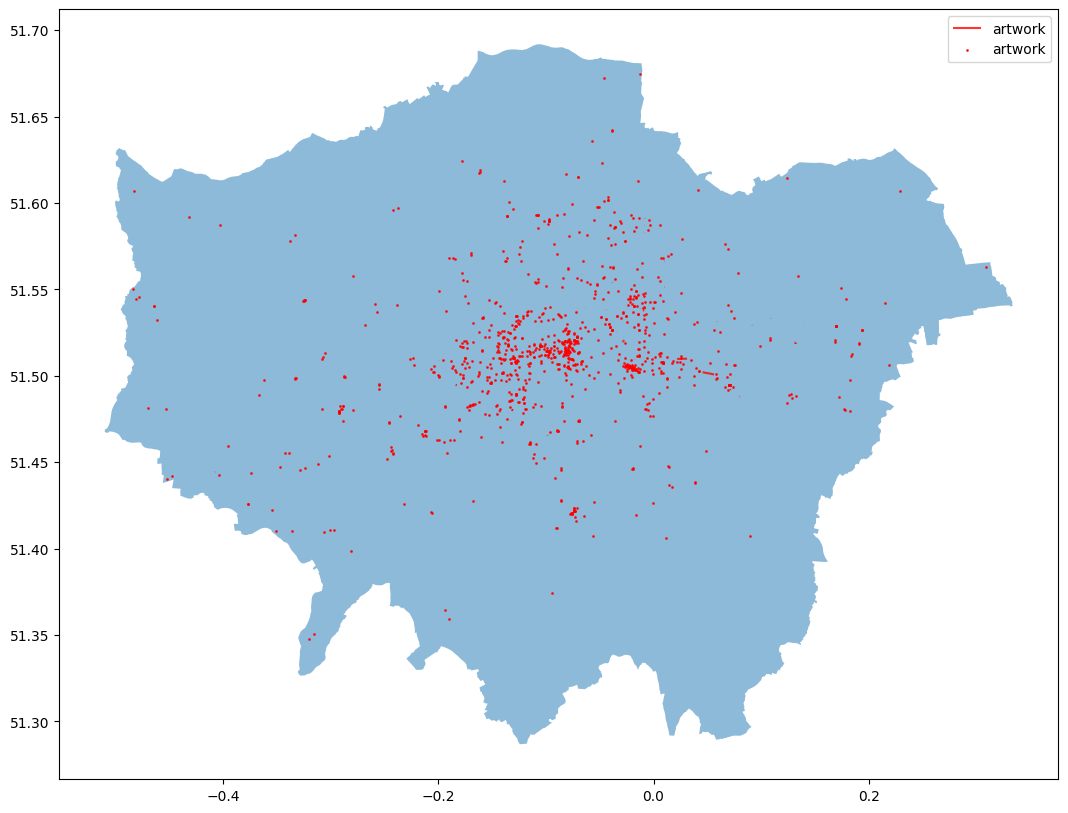

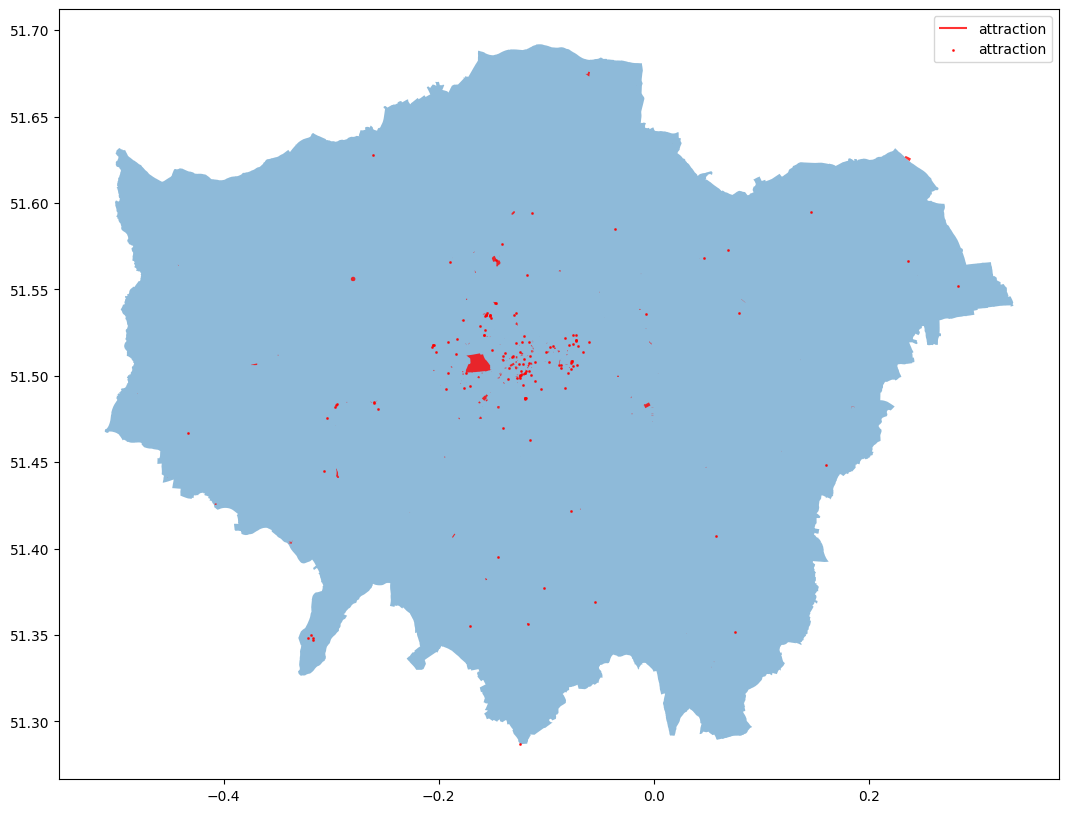

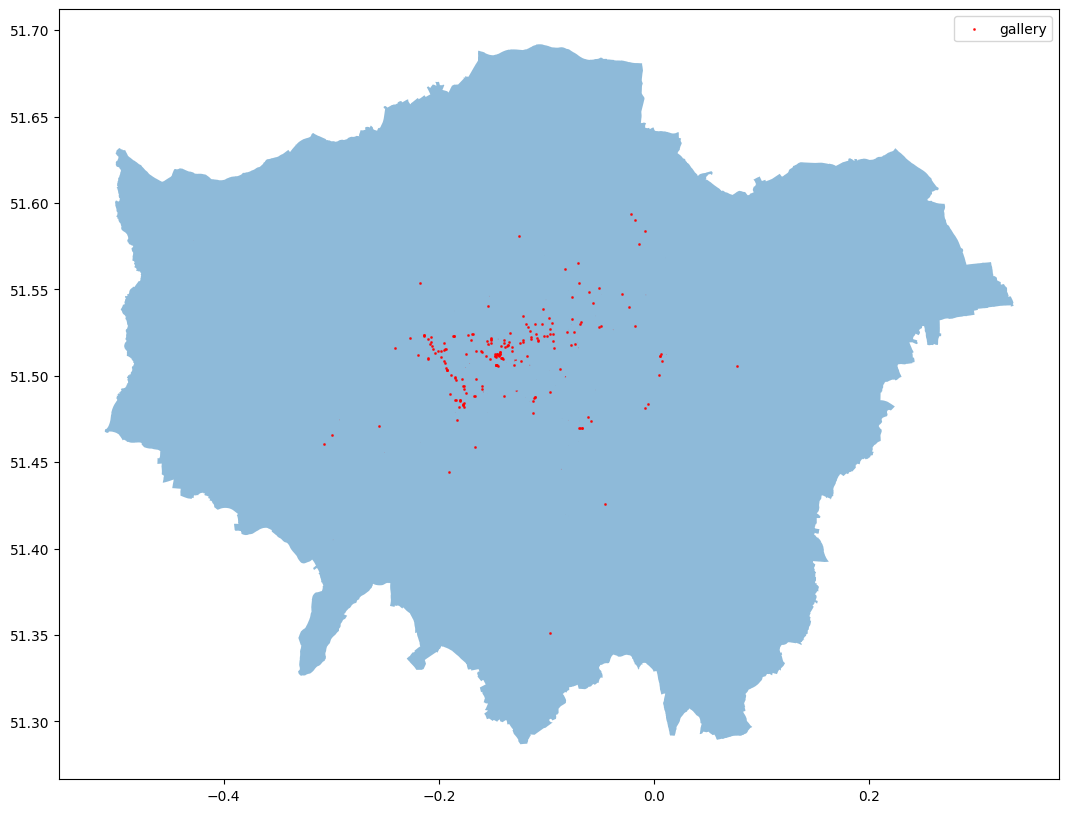

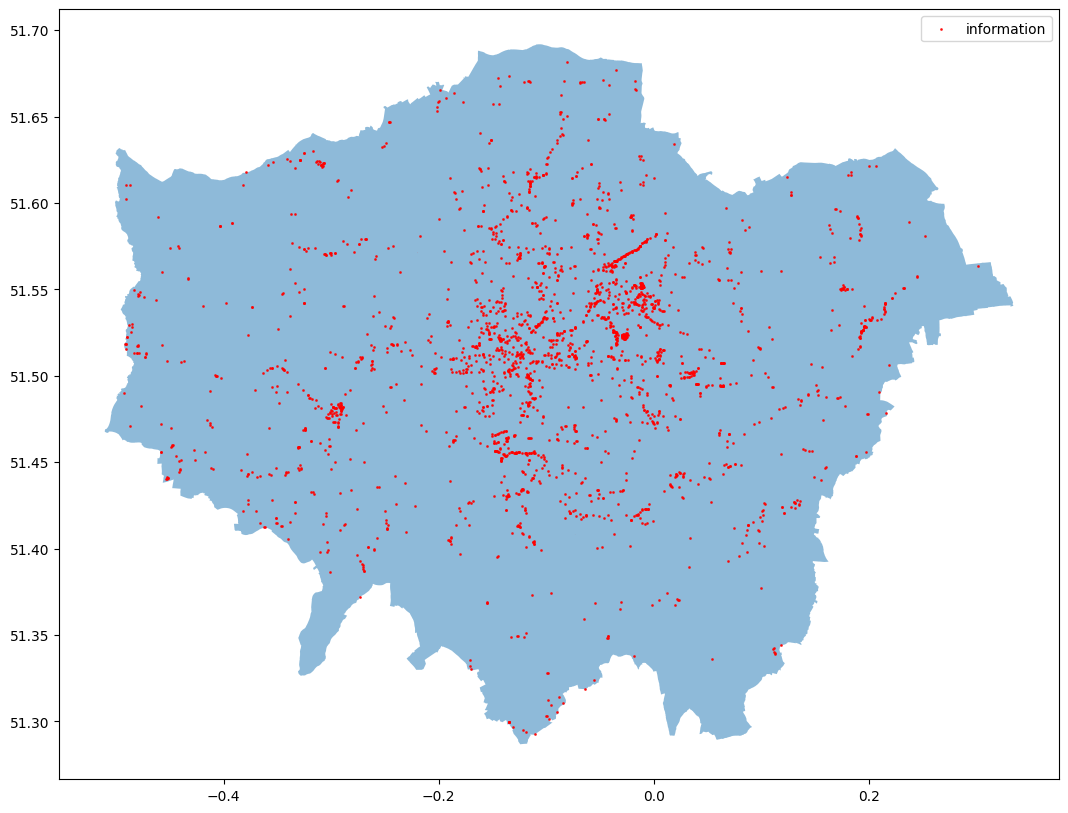

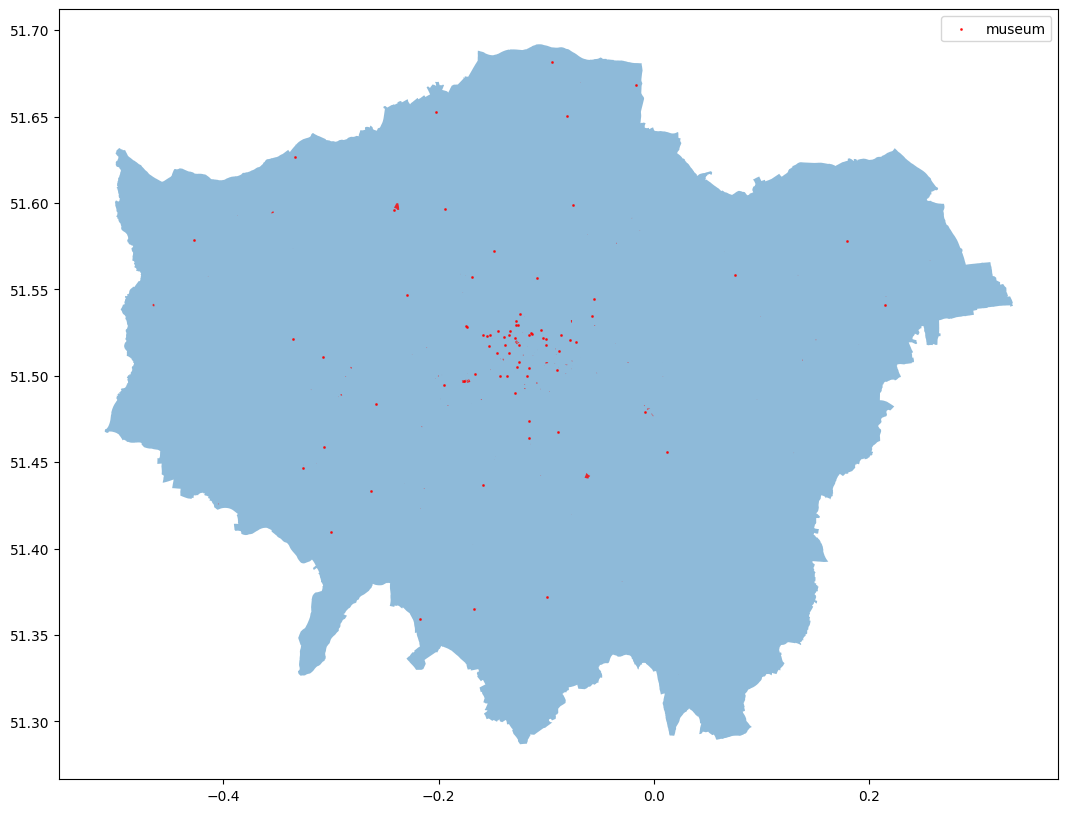

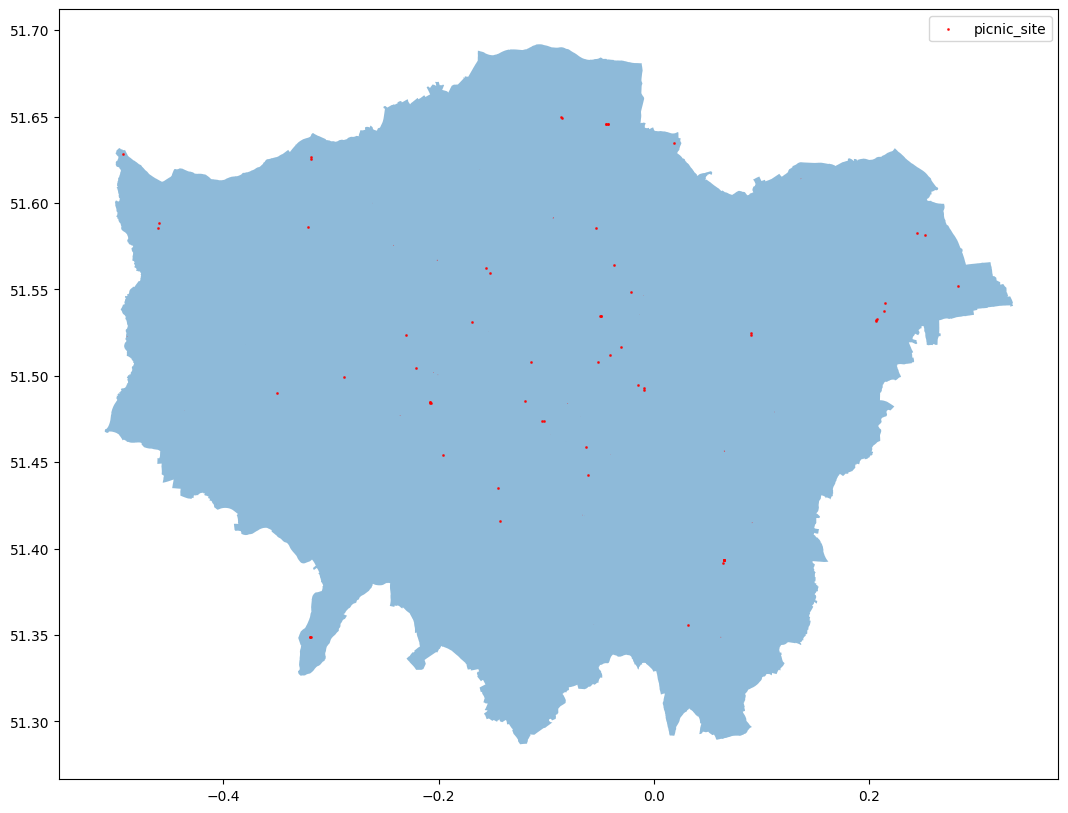

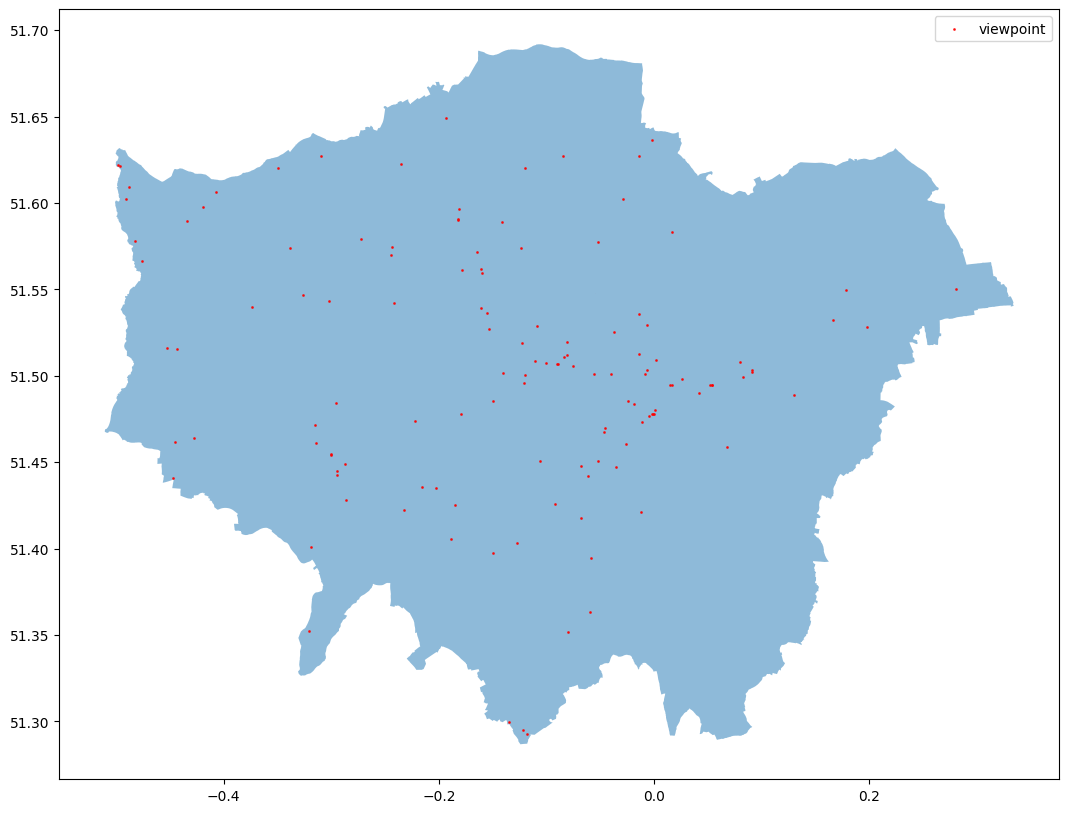

In [4]:
# Import
import osmnx as ox 
import matplotlib as mpl 
%matplotlib inline
from matplotlib import pyplot as plt
import os
import pandas as pd
import geopandas as gpd
import numpy as np
from shapely.geometry.polygon import Polygon
from shapely.geometry.multipolygon import MultiPolygon
import time
from scipy import spatial
from scipy.spatial import KDTree
import pickle

# Set up query
amenity_list = ['artwork','attraction','gallery','information','museum','picnic_site','viewpoint']
for u in amenity_list:
  print(u)
  query = {'tourism':u}

  # Run query
  restaurants_gdf = ox.geometries.geometries_from_place(
              'Greater London, UK',
              tags = query)

  restaurants_gdf.head(5)

  # Download London's Boundary
  london_gdf = ox.geocoder.geocode_to_gdf('Greater London, UK')

  print(london_gdf.head(5))
  # Set up a plot axis
  fig, ax = plt.subplots(figsize = (15,10))

  # Visualise both on the plot
  london_gdf.plot(ax = ax, alpha = 0.5)
  restaurants_gdf.plot(ax = ax, markersize = 1, color = 'red', alpha = 0.8, label = u)
  plt.legend()


  london_gdf['geometry'] = london_gdf['geometry'].apply(
    lambda x: x.centroid if type(x) == Polygon else (
    x.centroid if type(x) == MultiPolygon else x)
  )


  def get_local_crs(y,x):  
      x = ox.utils_geo.bbox_from_point((y, x), dist = 500, project_utm = True, return_crs = True)
      return x[-1]
    
  # Set London longitude and latitude
  lon_latitude = 51.509865
  lon_longitude = -0.118092

  local_utm_crs = get_local_crs(lon_latitude, lon_longitude)
  

  # Note below: "crs = 4326" is our way of telling geopandas that the initial projection uses the standard
  # longitude latitude coordinates. You can't manipulate the CRS if you haven't set one initially.

  air_gdf = gpd.GeoDataFrame(air_df, geometry = gpd.points_from_xy(air_df.longitude, air_df.latitude), crs = 4326)
  air_gdf = air_gdf.to_crs(local_utm_crs)

  #Convert amenities into local projection (amenities already had an initial CRS set when we downloaded it via OSMnx)
  restaurants_gdf = restaurants_gdf.to_crs(local_utm_crs)

  points = restaurants_gdf[restaurants_gdf.geometry.type == 'Point']
  Lon = points.geometry.apply(lambda x: x.x).values
  Lat = points.geometry.apply(lambda x: x.y).values
  coords = list(zip(Lat,Lon))
  tree = spatial.KDTree(coords)
  Lon = []
  Lat = []
  for geom in restaurants_gdf.geometry:
      if geom.type == 'Point':
          Lon.append(geom.x)
          Lat.append(geom.y)
      elif geom.type == 'Polygon':
          Lon.append(geom.centroid.x)
          Lat.append(geom.centroid.y)
  coords = list(zip(Lat, Lon))
  tree = spatial.KDTree(coords)

  
  file_name = f'D:/React-Projects/Mini-project/pickled_kdtree/kdtree_{u}.pkl'
  with open(file_name, 'wb') as file:
    pickle.dump(tree, file)

  def find_points_closeby(lat_lon, k = 500, max_distance = 1000 ):
    '''
    Queries a pre-existing kd tree and returns the number of points within x distance
    of long/lat point.
    lat_lon:        A longitude and latitude pairings in the (y, x) tuple form.
    k:              The maximum number of closest points to query
    max_distance:   The maximum distance (in meters)
    '''
    
    results = tree.query((lat_lon), k = k, distance_upper_bound= max_distance)
    zipped_results = list(zip(results[0], results[1]))
    zipped_results = [i for i in zipped_results if i[0] != np.inf]
    
    return len(zipped_results)

  # Set up a timer 
  import time 
  t0 = time.time()

  #Apply the function
  air_df[u] = air_gdf.apply(lambda row: find_points_closeby(
  (row.geometry.y, row.geometry.x)) , axis = 1)

  # Report the time
  time_passed = round(time.time() - t0, 2)
  print ("Completed in %s seconds" % (time_passed))

  print(air_df[['id',u]].head(5))






In [6]:
print(air_df.head(5))
air_df.to_csv('airbnb_rooms.csv')

   Unnamed: 0.5  Unnamed: 0.4  Unnamed: 0.3  Unnamed: 0.2  Unnamed: 0.1  \
0             0             0             0             0             0   
1             1             1             1             1             1   
2             2             2             2             2             2   
3             3             3             3             3             3   
4             4             4             4             4             4   

   Unnamed: 0     id     scrape_id  host_id  host_since  ...  nightclub  \
0           0  13913  2.020000e+13    54730         127  ...          0   
1           1  15400  2.020000e+13    60302         126  ...          4   
2           2  17402  2.020000e+13    67564         125  ...         15   
3           4  25023  2.020000e+13   102813         122  ...          0   
4           5  25123  2.020000e+13   103583         122  ...          0   

   theatre marketplace place_of_worship  artwork  attraction gallery  \
0        0           0    

In [ ]:
#Decision tree

In [1]:
# Import
import osmnx as ox 
import os
import pandas as pd
import geopandas as gpd
import numpy as np
from shapely.geometry.polygon import Polygon
from shapely.geometry.multipolygon import MultiPolygon
import time
from scipy import spatial
from scipy.spatial import KDTree
import pickle



  # Set up query
amenity_list = ['restaurant','bar','pub','hospital','cinema','nightclub','theatre','marketplace','place_of_worship']

for u in amenity_list:
  print(u)
  query = {'amenity':u}

  # Run query
  restaurants_gdf = ox.geometries.geometries_from_place(
              'Greater London, UK',
              tags = query)
  restaurants_gdf.head(5)

  london_gdf = ox.geocoder.geocode_to_gdf('Greater London, UK')
  london_gdf['geometry'] = london_gdf['geometry'].apply(
    lambda x: x.centroid if type(x) == Polygon else (
    x.centroid if type(x) == MultiPolygon else x)
  )


  def get_local_crs(y,x):  
      x = ox.utils_geo.bbox_from_point((y, x), dist = 500, project_utm = True, return_crs = True)
      return x[-1]
    
  # Set London longitude and latitude
  lon_latitude = 51.509865
  lon_longitude = -0.118092

  local_utm_crs = get_local_crs(lon_latitude, lon_longitude)

  #Convert amenities into local projection (amenities already had an initial CRS set when we downloaded it via OSMnx)
  restaurants_gdf = restaurants_gdf.to_crs(local_utm_crs)

  points = restaurants_gdf[restaurants_gdf.geometry.type == 'Point']
  Lon = points.geometry.apply(lambda x: x.x).values
  Lat = points.geometry.apply(lambda x: x.y).values
  coords = list(zip(Lat,Lon))
  tree = spatial.KDTree(coords)

  Lon = []
  Lat = []
  for geom in restaurants_gdf.geometry:
      if geom.geom_type == 'Point':
          Lon.append(geom.x)
          Lat.append(geom.y)
      elif geom.geom_type == 'Polygon':
          Lon.append(geom.centroid.x)
          Lat.append(geom.centroid.y)
  coords = list(zip(Lat, Lon))

  tree = spatial.KDTree(coords)
  if isinstance(tree, KDTree):
    print("KD tree successfully loaded.")
  else:
    print("Failed to load KD tree.")

  file_name = f'D:/React-Projects/Mini-project/pickled_kdtree/kdtree_{u}.pkl'
  with open(file_name, 'wb') as file:
    pickle.dump(tree, file)





restaurant
KD tree successfully loaded.
bar
KD tree successfully loaded.
pub
KD tree successfully loaded.
hospital
KD tree successfully loaded.
cinema
KD tree successfully loaded.
nightclub
KD tree successfully loaded.
theatre
KD tree successfully loaded.
marketplace
KD tree successfully loaded.
place_of_worship
KD tree successfully loaded.


In [2]:
# tourist-------------------------

# Set up query
amenity_list = ['artwork','attraction','gallery','information','museum','picnic_site','viewpoint']

for u in amenity_list:
  print(u)
  query = {'tourism':u}

  # Run query
  restaurants_gdf = ox.geometries.geometries_from_place(
              'Greater London, UK',
              tags = query)

  restaurants_gdf.head(5)

  london_gdf = ox.geocoder.geocode_to_gdf('Greater London, UK')
  london_gdf['geometry'] = london_gdf['geometry'].apply(
    lambda x: x.centroid if type(x) == Polygon else (
    x.centroid if type(x) == MultiPolygon else x)
  )


  def get_local_crs(y,x):  
      x = ox.utils_geo.bbox_from_point((y, x), dist = 500, project_utm = True, return_crs = True)
      return x[-1]
    
  # Set London longitude and latitude
  lon_latitude = 51.509865
  lon_longitude = -0.118092

  local_utm_crs = get_local_crs(lon_latitude, lon_longitude)

  #Convert amenities into local projection (amenities already had an initial CRS set when we downloaded it via OSMnx)
  restaurants_gdf = restaurants_gdf.to_crs(local_utm_crs)

  
  points = restaurants_gdf[restaurants_gdf.geometry.type == 'Point']
  Lon = points.geometry.apply(lambda x: x.x).values
  Lat = points.geometry.apply(lambda x: x.y).values
  coords = list(zip(Lat,Lon))
  tree = spatial.KDTree(coords)
  Lon = []
  Lat = []
  for geom in restaurants_gdf.geometry:
      if geom.geom_type == 'Point':
          Lon.append(geom.x)
          Lat.append(geom.y)
      elif geom.geom_type == 'Polygon':
          Lon.append(geom.centroid.x)
          Lat.append(geom.centroid.y)
  coords = list(zip(Lat, Lon))

  tree = spatial.KDTree(coords)
  if isinstance(tree, KDTree):
    print("KD tree successfully loaded.")
  else:
    print("Failed to load KD tree.")

  file_name = f'D:/React-Projects/Mini-project/pickled_kdtree/kdtree_{u}.pkl'
  with open(file_name, 'wb') as file:
    pickle.dump(tree, file)

artwork
KD tree successfully loaded.
attraction
KD tree successfully loaded.
gallery
KD tree successfully loaded.
information
KD tree successfully loaded.
museum
KD tree successfully loaded.
picnic_site
KD tree successfully loaded.
viewpoint
KD tree successfully loaded.
